In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix


In [3]:
# Load the dataset
df_train_model = pd.read_csv('df_sentiment_embeddings.csv')

In [4]:
# Prepare data for XGBoost
X = df_train_model.drop(columns='sentiment')  # Features (Word2Vec representations)
y = df_train_model['sentiment']  # Labels


# Mapping labels from [-1, 0, 1] to [0, 1, 2]
# 0 = negative review
# 1 = neutral review
# 2 = positive review
class_mapping = {-1: 0, 0: 1, 1: 2}
y = y.map(class_mapping)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Perform PCA for dimensionality reduction
n_components = 20  # Specify the number of components (adjust as needed)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Feature scaling (recommended for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Specify the SVM classifier for multi-class classification
svm_model = SVC(kernel='rbf', C=10, gamma='scale', decision_function_shape='ovr', random_state=42)
# 'ovr' stands for 'one-vs-rest' strategy for multi-class classification

# Train the SVM classifier
svm_model.fit(X_train_scaled, y_train)



SVC(C=10, random_state=42)

In [10]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='orange')

    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


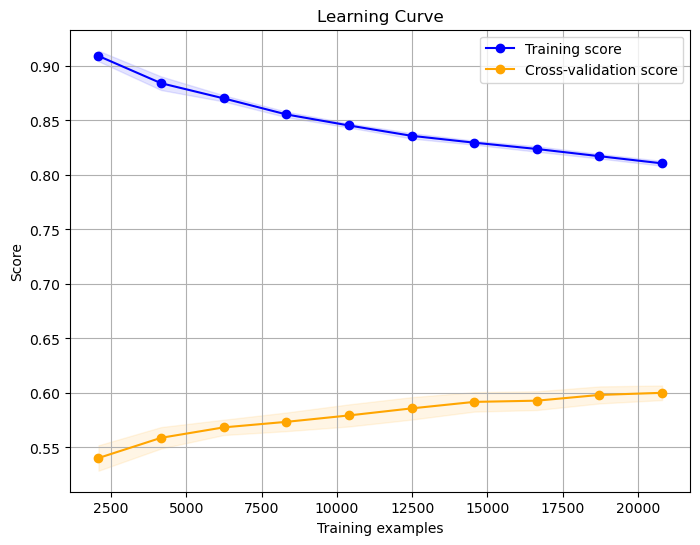

In [13]:
# Plot the learning curve
plot_learning_curve(svm_model, X_train_scaled, y_train)

In [22]:
# Predict on the test set
y_pred_svm_train = svm_model.predict(X_train_scaled)
y_pred_svm_test = svm_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_svm_train = accuracy_score(y_train, y_pred_svm_train)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm_test)
precision_svm = precision_score(y_test, y_pred_svm_test, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm_test, average='weighted')


print(f"SVM Accuracy of train data: {accuracy_svm_train:.4f}")
print(f"SVM Accuracy of test data: {accuracy_svm_test:.4f}")
print(f"SVM Precision: {precision_svm:.4f}")
print(f"SVM Recall: {recall_svm:.4f}")

SVM Accuracy of train data: 0.8026
SVM Accuracy of test data: 0.6096
SVM Precision: 0.5976
SVM Recall: 0.6096


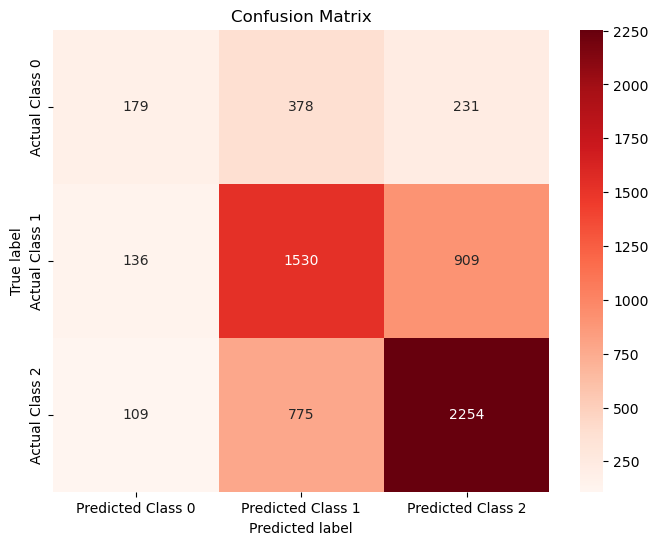

In [23]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
num_classes = 3
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted Class ' + str(i) for i in range(num_classes)],
                              index=['Actual Class ' + str(i) for i in range(num_classes)])

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Reds', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()